In [1]:
%load_ext watermark

In [2]:
%watermark

Last updated: 2022-07-04T20:39:54.495831+03:00

Python implementation: CPython
Python version       : 3.7.10
IPython version      : 7.22.0

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 9, GenuineIntel
CPU cores   : 8
Architecture: 64bit



In [3]:
import os
import pickle as pkl

import numpy as np
import pandas as pd

from sklearn.metrics import r2_score
from catboost import CatBoostRegressor, Pool

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from catboost import __version__ as cb_version
from sklearn import __version__ as sklearn_version

print(f'cb_version: {cb_version}')
print(f'sklearn_version: {sklearn_version}')

cb_version: 0.24.3
sklearn_version: 0.24.2


In [5]:
%watermark --iversions

matplotlib: 3.3.4
pandas    : 0.25.3
numpy     : 1.20.3
seaborn   : 0.11.1



## Reproducibility block

In [6]:
# seed the RNG for all devices (both CPU and CUDA)
#torch.manual_seed(1984)

#Disabling the benchmarking feature causes cuDNN to deterministically select an algorithm, 
#possibly at the cost of reduced performance.
#torch.backends.cudnn.benchmark = False

# for custom operators,
import random
random.seed(5986721)

# 
np.random.seed(62185)

#sklearn take seed from a line abowe

CB_RANDOMSEED = 309487

In [7]:
DIR_DATA   = os.path.join(os.getcwd(), 'data')
DIR_MODELS = os.path.join(os.getcwd(), 'models')
DIR_SUBM   = os.path.join(os.getcwd(), 'subm')
DIR_SUBM_PART = os.path.join(os.getcwd(), 'subm', 'partial')

## Load data

In [8]:
x_train  = pd.read_csv(os.path.join(DIR_DATA, 'x_train.csv'), index_col= 0)
x_val    = pd.read_csv(os.path.join(DIR_DATA, 'x_val.csv'), index_col= 0)
df_test  = pd.read_csv(os.path.join(DIR_DATA, 'test_upd.csv'), index_col= 0)

with open(os.path.join(DIR_DATA, 'cat_columns.pkl'), 'rb') as pickle_file:
    cat_cols = pkl.load(pickle_file)
    
with open(os.path.join(DIR_DATA, 'num_columns.pkl'), 'rb') as pickle_file:
    num_cols = pkl.load(pickle_file)

In [9]:
x_train.shape, x_val.shape, df_test.shape, len(cat_cols), len(num_cols)

((5589, 1232), (1398, 1232), (3000, 1229), 4, 1193)

In [10]:
cat_cols = cat_cols + ['category']
print(cat_cols)

['hour', 'dow', 'day', 'mounth', 'category']


отделяем метки от данных

In [11]:
y_train = x_train[['views', 'depth', 'full_reads_percent']]
y_val   = x_val[['views', 'depth', 'full_reads_percent']]

x_train.drop(['views', 'depth', 'full_reads_percent'], axis = 1, inplace = True)
x_val.drop(  ['views', 'depth', 'full_reads_percent'], axis = 1, inplace = True)

x_train.shape, x_val.shape, y_train.shape, y_val.shape

((5589, 1229), (1398, 1229), (5589, 3), (1398, 3))

In [12]:
x_train.shape

(5589, 1229)

In [13]:
#cat_cols + num_cols


In [14]:
#views
train_ds_views = Pool(x_train[cat_cols + num_cols],
#train_ds_views = Pool(x_train[cat_cols + ['ctr']],
                      y_train[['views']],
                      cat_features = cat_cols,
                      #feature_names = cat_cols + num_cols
                     )

val_ds_views   = Pool(x_val[cat_cols + num_cols],
#val_ds_views   = Pool(x_val[cat_cols + ['ctr']],
                      y_val[['views']],
                      cat_features = cat_cols,
                      #feature_names = cat_cols + num_cols
                     )


#depth
train_ds_depth = Pool(x_train[cat_cols + num_cols],
                      y_train[['depth']],
                      cat_features = cat_cols,
                      feature_names = cat_cols + num_cols
                     )

val_ds_depth   = Pool(x_val[cat_cols + num_cols],
                      y_val[['depth']],
                      cat_features = cat_cols,
                      feature_names = cat_cols + num_cols
                     )


#full_reads_percent
train_ds_frp = Pool(x_train[cat_cols + num_cols],
                      y_train[['full_reads_percent']],
                      cat_features = cat_cols,
                      feature_names = cat_cols + num_cols
                     )

val_ds_frp   = Pool(x_val[cat_cols + num_cols],
                      y_val[['full_reads_percent']],
                      cat_features = cat_cols,
                      feature_names = cat_cols + num_cols
                     )

In [15]:
def plot_feature_importance2(inp_model, inp_pool, imp_number = 30):
    
    data = pd.DataFrame({'feature_importance': inp_model.get_feature_importance(inp_pool), 
              'feature_names': inp_pool.get_feature_names()}).sort_values(by=['feature_importance'], 
                                                       ascending=True)
    
    data.nlargest(imp_number, columns="feature_importance").plot(kind='barh', figsize = (30,16)) ## plot top 40 features

In [16]:
def plot_feature_importance(importance,names,model_type, imp_number = 30):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'][:imp_number], y=fi_df['feature_names'][:imp_number])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

## views

In [17]:
cb_model_views = CatBoostRegressor(iterations=20,
                                 learning_rate=0.1,
                                 depth=4,
                                 random_seed = CB_RANDOMSEED,
                   #n_estimators=100,
                                  )
# Fit model
cb_model_views.fit(train_ds_views,
        #train_data, train_labels,
                   eval_set=val_ds_views, 
                   #plot = True,
                  )

0:	learn: 101577.2373104	test: 51248.0564346	best: 51248.0564346 (0)	total: 222ms	remaining: 4.22s
1:	learn: 98412.4472157	test: 50111.6609937	best: 50111.6609937 (1)	total: 275ms	remaining: 2.47s
2:	learn: 96229.9889550	test: 49366.9953931	best: 49366.9953931 (2)	total: 326ms	remaining: 1.85s
3:	learn: 91706.8384341	test: 48331.3600390	best: 48331.3600390 (3)	total: 375ms	remaining: 1.5s
4:	learn: 89803.0480041	test: 47247.4409238	best: 47247.4409238 (4)	total: 428ms	remaining: 1.28s
5:	learn: 87661.7874914	test: 46117.5041501	best: 46117.5041501 (5)	total: 486ms	remaining: 1.13s
6:	learn: 87084.6968559	test: 45505.4986313	best: 45505.4986313 (6)	total: 548ms	remaining: 1.02s
7:	learn: 84748.1958961	test: 45362.9678892	best: 45362.9678892 (7)	total: 596ms	remaining: 894ms
8:	learn: 84048.3400818	test: 44841.6707121	best: 44841.6707121 (8)	total: 648ms	remaining: 792ms
9:	learn: 81824.4304339	test: 44502.4414681	best: 44502.4414681 (9)	total: 700ms	remaining: 700ms
10:	learn: 79734.981

In [18]:
# Get predictions and metrics
preds_train_views = cb_model_views.predict(x_train[cat_cols + num_cols])
preds_val_views   = cb_model_views.predict(val_ds_views)

train_score_views = r2_score(y_train["views"], preds_train_views)
val_score_views   = r2_score(y_val["views"],   preds_val_views)

train_score_views, val_score_views

(0.5540945603335543, 0.33130127098182605)

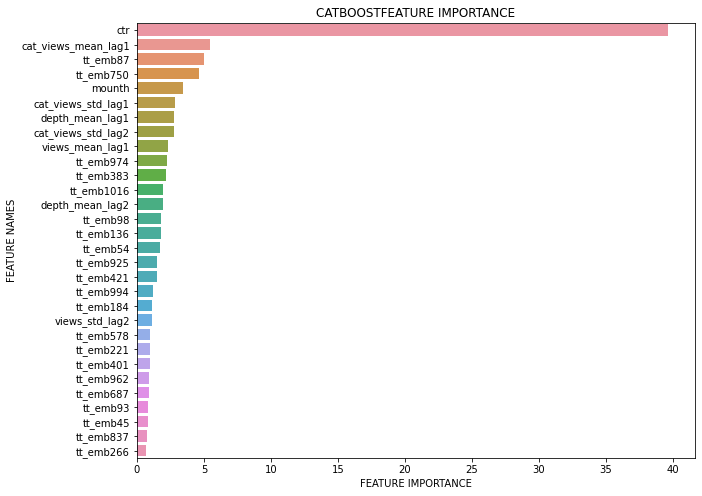

In [19]:
#plot_feature_importance(cb_model_views, train_ds_views, 30)
plot_feature_importance(cb_model_views.get_feature_importance(), train_ds_views.get_feature_names(), 'CATBOOST')

## depth

In [20]:
cb_model_depth = CatBoostRegressor(#iterations=1000,
                                 learning_rate=0.05,
                                 depth=10,
                                 random_seed = CB_RANDOMSEED,
                   n_estimators=100,
                                  )
# Fit model
cb_model_depth.fit(train_ds_depth,
                   eval_set=val_ds_depth, 
                   #plot = True,
                  )

0:	learn: 0.0646009	test: 0.0583989	best: 0.0583989 (0)	total: 3.35s	remaining: 5m 31s
1:	learn: 0.0630146	test: 0.0567958	best: 0.0567958 (1)	total: 6.55s	remaining: 5m 20s
2:	learn: 0.0614599	test: 0.0552927	best: 0.0552927 (2)	total: 9.88s	remaining: 5m 19s
3:	learn: 0.0600313	test: 0.0540194	best: 0.0540194 (3)	total: 12.9s	remaining: 5m 10s
4:	learn: 0.0585662	test: 0.0526665	best: 0.0526665 (4)	total: 16.4s	remaining: 5m 12s
5:	learn: 0.0572381	test: 0.0513844	best: 0.0513844 (5)	total: 19.9s	remaining: 5m 11s
6:	learn: 0.0558646	test: 0.0501626	best: 0.0501626 (6)	total: 22.9s	remaining: 5m 4s
7:	learn: 0.0546010	test: 0.0489445	best: 0.0489445 (7)	total: 25.9s	remaining: 4m 58s
8:	learn: 0.0534925	test: 0.0479107	best: 0.0479107 (8)	total: 29s	remaining: 4m 52s
9:	learn: 0.0524061	test: 0.0469445	best: 0.0469445 (9)	total: 31.9s	remaining: 4m 47s
10:	learn: 0.0513083	test: 0.0460171	best: 0.0460171 (10)	total: 35.1s	remaining: 4m 44s
11:	learn: 0.0503817	test: 0.0451388	best: 0

In [21]:
# Get predictions and metrics
preds_train_depth = cb_model_depth.predict(x_train[cat_cols + num_cols])
preds_val_depth   = cb_model_depth.predict(val_ds_depth)

train_score_depth = r2_score(y_train["depth"], preds_train_depth)
val_score_depth   = r2_score(y_val["depth"],   preds_val_depth)

train_score_depth, val_score_depth

(0.8528653999306899, 0.7262589281971181)

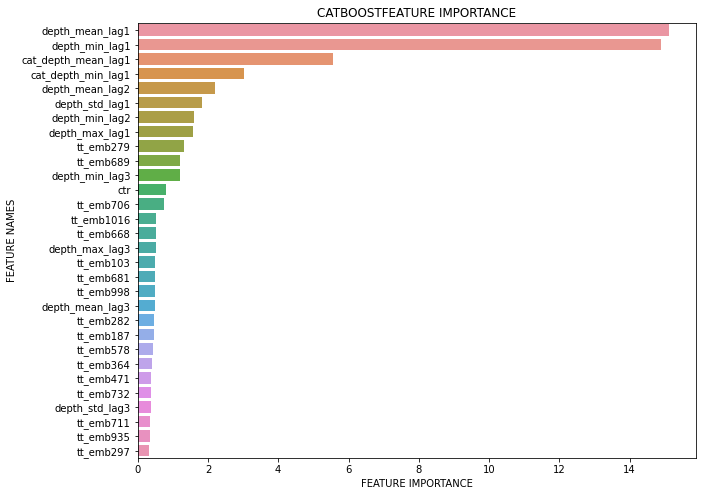

In [22]:
#plot_feature_importance(cb_model_views, train_ds_views, 30)
plot_feature_importance(cb_model_depth.get_feature_importance(), train_ds_depth.get_feature_names(), 'CATBOOST')

## full_reads_percent

In [23]:
cb_model_frp = CatBoostRegressor(#iterations=1000,
                                 learning_rate=0.05,
                                 depth=10,
                                 random_seed = CB_RANDOMSEED,
                   n_estimators=100,
                                 #n_estimators=100,
    #num_trees=None,
                                )
# Fit model
cb_model_frp.fit(train_ds_frp,
                   eval_set=val_ds_frp, 
                   #plot = True,
                  )

0:	learn: 10.0481067	test: 10.1402608	best: 10.1402608 (0)	total: 3.26s	remaining: 5m 23s
1:	learn: 9.9254738	test: 10.0404483	best: 10.0404483 (1)	total: 6.38s	remaining: 5m 12s
2:	learn: 9.8181263	test: 9.9508463	best: 9.9508463 (2)	total: 9.48s	remaining: 5m 6s
3:	learn: 9.7165217	test: 9.8594756	best: 9.8594756 (3)	total: 12.9s	remaining: 5m 9s
4:	learn: 9.6121735	test: 9.7729190	best: 9.7729190 (4)	total: 16.3s	remaining: 5m 10s
5:	learn: 9.5244095	test: 9.7006915	best: 9.7006915 (5)	total: 19.6s	remaining: 5m 7s
6:	learn: 9.4310562	test: 9.6366480	best: 9.6366480 (6)	total: 22.9s	remaining: 5m 4s
7:	learn: 9.3421128	test: 9.5704519	best: 9.5704519 (7)	total: 26.3s	remaining: 5m 2s
8:	learn: 9.2598212	test: 9.5100742	best: 9.5100742 (8)	total: 30.3s	remaining: 5m 6s
9:	learn: 9.1786191	test: 9.4565214	best: 9.4565214 (9)	total: 34.1s	remaining: 5m 6s
10:	learn: 9.0965591	test: 9.4006810	best: 9.4006810 (10)	total: 37.5s	remaining: 5m 3s
11:	learn: 9.0162247	test: 9.3590341	best: 9

In [24]:
# Get predictions and metrics
preds_train_frp = cb_model_frp.predict(x_train[cat_cols + num_cols])
preds_val_frp   = cb_model_frp.predict(val_ds_frp)

train_score_frp = r2_score(y_train["full_reads_percent"], preds_train_frp)
val_score_frp   = r2_score(y_val["full_reads_percent"],   preds_val_frp)

train_score_frp, val_score_frp

(0.6631276724054295, 0.34064497648434666)

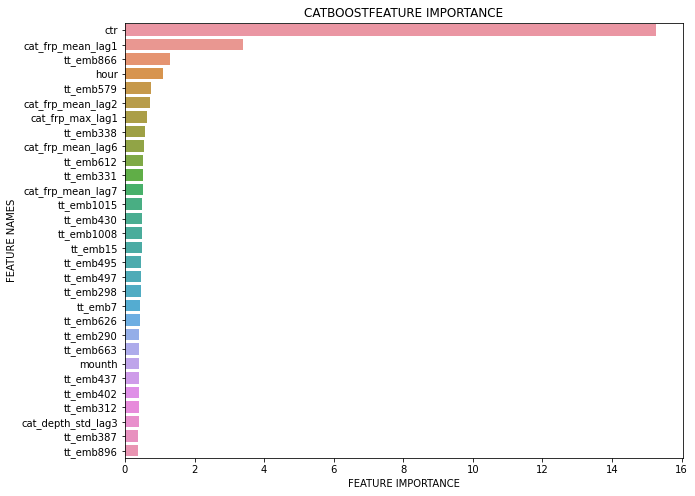

In [25]:
#plot_feature_importance(cb_model_views, train_ds_views, 30)
plot_feature_importance(cb_model_frp.get_feature_importance(), train_ds_frp.get_feature_names(), 'CATBOOST')

In [26]:
score_train = 0.4 * train_score_views + 0.3 * train_score_depth + 0.3 * train_score_frp
score_val  = 0.4 * val_score_views  + 0.3 * val_score_depth  + 0.3 * val_score_frp

score_train, score_val

(0.6764357458342576, 0.45259167979716985)

In [27]:
NTRY = 5

## save models

In [28]:
cb_model_views.save_model(os.path.join(DIR_MODELS, f'{NTRY}_cb_views.cbm'), 
                           format="cbm",
                           export_parameters=None,
                           pool=None
                         )

cb_model_depth.save_model(os.path.join(DIR_MODELS, f'{NTRY}_cb_depth.cbm'), 
                           format="cbm",
                           export_parameters=None,
                           pool=None
                         )

cb_model_frp.save_model(os.path.join(DIR_MODELS, f'{NTRY}_cb_frp.cbm'), 
                           format="cbm",
                           export_parameters=None,
                           pool=None
                         )

## make predict

In [29]:
pred_views = cb_model_views.predict(df_test[cat_cols + num_cols])
pred_depth = cb_model_depth.predict(df_test[cat_cols + num_cols])
pred_frp   = cb_model_frp.predict(  df_test[cat_cols + num_cols])

In [30]:
subm = pd.DataFrame()
subm['document_id'] = df_test.index

subm['views'] = pred_views
subm['depth'] = pred_depth
subm['full_reads_percent'] = pred_frp

In [31]:
subm.head()

,document_id,views,depth,full_reads_percent
0,0,21250.214853,1.166102,36.719013
1,1,15294.680917,1.053989,30.404943
2,2,58432.564140,1.060764,29.163220
3,3,13884.303112,1.064296,35.927047
4,4,118997.748920,1.149199,30.465089


In [32]:
subm.to_csv(os.path.join(DIR_SUBM, f'{NTRY}_cb_ttls_emd_lags.csv'), index = False)